BlockSeparation+NonLinearEncoder+**LocationEmbedding**+UNetdecoder

**Variable:alpha**

4*4kernel,1:8,

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt 
import sys
import time
import pandas as pd
import csv

In [16]:

from datetime import datetime
now = datetime.now()
formatted_date = now.strftime("%m%d")
formatted_date = int(formatted_date)
print(formatted_date)

import os
home_directory = os.path.expanduser('~')
onedrive_folder_name = 'OneDrive'
onedrive_path = os.path.join(home_directory, onedrive_folder_name)
save_directory = os.path.join(onedrive_path,'CODES', 'konishi_AutoEncoder', 'AutoEncoder_data02', 'MNIST_[004]α_result') #保存先のファイル名を入力
print(save_directory)
os.makedirs(save_directory, exist_ok=True)


1219
/Users/konishi/OneDrive/CODES/konishi_AutoEncoder/AutoEncoder_data02/MNIST_[004]α_result


In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [18]:
import os
home_directory = os.path.expanduser('~')
onedrive_folder_name = 'OneDrive'
onedrive_path = os.path.join(home_directory, onedrive_folder_name)

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0),(1)),lambda x: x.view(-1)])

root = os.path.join(onedrive_path,'CODES','samples','mnist_data')
mnist_train = datasets.MNIST(root=root,download=True,train=True,transform=transform)
mnist_test = datasets.MNIST(root=root,download=True,train=False,transform=transform)

train_dataloader = DataLoader(mnist_train,batch_size=100,shuffle=True)
test_dataloader = DataLoader(mnist_test,batch_size=100,shuffle=False)

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [20]:
def split_into_kernels(image, kernel_size):

    b,c,h,w = image.shape
    kernels = image.unfold(2, kernel_size, kernel_size).unfold(3, kernel_size, kernel_size)
    kernels = kernels.contiguous().view(b, -1, kernel_size, kernel_size)

    return kernels

In [21]:
#Encoder5DX(パッチ分割，位置埋め込みを想定)
class Encoder(nn.Module):
    def __init__(self,kernel_size,leverage,alpha):
        super(Encoder, self).__init__()
        self.kernel_size = kernel_size
        self.leverage = leverage
        self.alpha = alpha

        kernel_in = int(kernel_size**2)
        real_part = nn.Parameter(torch.randn(int(kernel_in/leverage), kernel_in) * (1/np.sqrt(kernel_in)))
        imag_part = nn.Parameter(torch.randn(int(kernel_in/leverage), kernel_in) * (1/np.sqrt(kernel_in)))

        self.B = torch.complex(real_part, imag_part).detach().to(device)
        self.B.requires_grad = False
    
    def forward(self, x):
        b, n_patches, k, _ = x.shape
        x = x.view(b*n_patches, -1) 
        x = torch.exp(1j * self.alpha * x) 
        x = x.T  
        x = torch.matmul(self.B, x).T  
        x = torch.abs(x)**2 
        return x, n_patches 
    

In [22]:
class PositionalEmbedder(nn.Module):
    def __init__(self, img_size, kernel_size, pos_embed_dim=8):
        super(PositionalEmbedder, self).__init__()
        self.kernel_size = kernel_size
        self.img_size = img_size
        self.pos_embed_dim = pos_embed_dim

        self.num_patches_x = img_size // kernel_size
        self.num_patches_y = img_size // kernel_size


        self.embed_x = nn.Embedding(self.num_patches_x, self.pos_embed_dim)
        self.embed_y = nn.Embedding(self.num_patches_y, self.pos_embed_dim)

    def forward(self, x, b, n_patches):

       
        patch_ids = torch.arange(n_patches, device=x.device)

        ix = patch_ids % self.num_patches_x
        iy = patch_ids // self.num_patches_x

        pos_x = self.embed_x(ix) 
        pos_y = self.embed_y(iy) 

        pos_info = torch.cat([pos_x, pos_y], dim=1) 
        pos_info = pos_info.unsqueeze(0).expand(b, -1, -1).contiguous().view(b*n_patches, -1)

        x = torch.cat([x, pos_info], dim=1) 
        x = x.view(b, n_patches, -1)
        x = x.view(b, -1)
        return x

In [23]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, 1, bias=False)
        else:
            self.shortcut = None

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.shortcut is not None:
            residual = self.shortcut(residual)#outと同じチャンネル数に合わせる
        out += residual#残差接続
        out = self.relu(out)
        return out
    
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpBlock, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(inplace=True)

    def forward(self, x):
        x = self.up(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class UNetDecoder(nn.Module):
    def __init__(self, num_in,ch):
        super(UNetDecoder, self).__init__()

        self.ch = ch
        self.fc = nn.Linear(num_in, ch*7*7)
        self.bottleneck = ResidualBlock(ch,ch,3)
        self.up1 = UpBlock(ch,ch)
        self.res1 = ResidualBlock(ch+ch,ch,3)
        self.up2 = UpBlock(ch,ch)
        self.res2 = ResidualBlock(ch+ch,ch,3)
        self.out_conv = nn.Conv2d(ch+ch, 1, 1, bias=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b = x.size(0)
        x = self.fc(x)
        x = x.view(b, self.ch, 7, 7) 
        x0 = self.bottleneck(x)  
        x1 = self.up1(x0) 
        x0_upsampled = F.interpolate(x0, scale_factor=2, mode='nearest') 
        x1 = torch.cat([x1, x0_upsampled], dim=1)
        x1 = self.res1(x1)
        x2 = self.up2(x1)
        x1_up = F.interpolate(x1, scale_factor=2, mode='nearest')
        x2 = torch.cat([x2, x1_up], dim=1)
        x_out = self.out_conv(x2)
        x_out = self.sigmoid(x_out) 
        x_out = x_out.view(b, -1)  
        return x_out


In [24]:
class AutoEncoder(nn.Module):
    def __init__(self, DofIN, kernel_size, leverage, ch, pos_embed_dim,alpha):
        super(AutoEncoder, self).__init__()
        self.kernel_size = kernel_size
        
        kernel_in = kernel_size**2
        feat_dim = int(kernel_in/leverage)
        num_patches = (28//kernel_size)*(28//kernel_size)
        total_dim = num_patches*(feat_dim + 2*pos_embed_dim)
        img_size = int(np.sqrt(DofIN))
        self.pos_embed_dim = pos_embed_dim
        
        self.encoder = Encoder(kernel_size,leverage,alpha)
        self.pos_embedder = PositionalEmbedder(img_size,kernel_size,pos_embed_dim)  
        self.decoder = UNetDecoder(total_dim, ch)
    def forward(self, x):
        x = x.view(x.size(0), 1, 28, 28)  
        x = split_into_kernels(x, self.kernel_size) 
        x,n_patches = self.encoder(x) 
        b = x.size(0)//n_patches
        x = self.pos_embedder(x,b,n_patches)
        x_reconstructed = self.decoder(x)
        return x_reconstructed

In [25]:
#MNISTのイメージを表示するやつ
def show_images(images, labels, title):
    images = images.view(images.size(0), 1, 28, 28)
    np.set_printoptions(precision=2)
    #print(images[1,0].double().numpy())
    images = images.detach().numpy()
    fig, axes = plt.subplots(1, 3, figsize=(10, 2))
    selected_digits = [5, 2, 4] ##
    selected_indices = [] 
    for digit in selected_digits:
        idx = (labels == digit).nonzero(as_tuple=True)[0]
        if len(idx) > 0:
            selected_indices.append(idx[0].item())
    for i, ax in enumerate(axes):
        if i < len(selected_indices):
            ax.imshow(images[selected_indices[i], 0], cmap='gray')
        ax.axis('off')
    plt.suptitle(title)

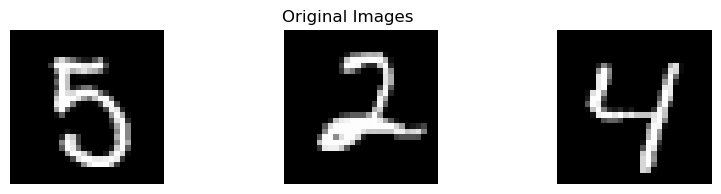

In [26]:
for i, (test_images, test_labels) in enumerate(test_dataloader):
    if i == 2:##
        break
show_images(test_images, test_labels,"Original Images")
plt.show()

In [27]:
def ssim_loss(img1, img2):

    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    mu1 = F.avg_pool2d(img1, kernel_size=3, stride=1, padding=1)
    mu2 = F.avg_pool2d(img2, kernel_size=3, stride=1, padding=1)

    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.avg_pool2d(img1 ** 2, kernel_size=3, stride=1, padding=1) - mu1_sq
    sigma2_sq = F.avg_pool2d(img2 ** 2, kernel_size=3, stride=1, padding=1) - mu2_sq
    sigma12 = F.avg_pool2d(img1 * img2, kernel_size=3, stride=1, padding=1) - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1)*(2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()

α=0.20 1th Epoch: 9/10

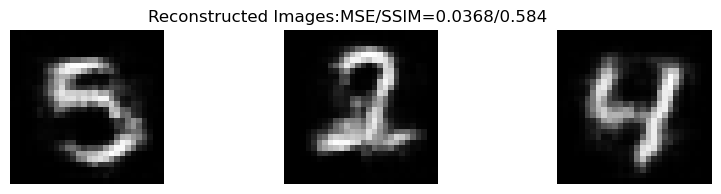

α=0.20 2th Epoch: 9/10

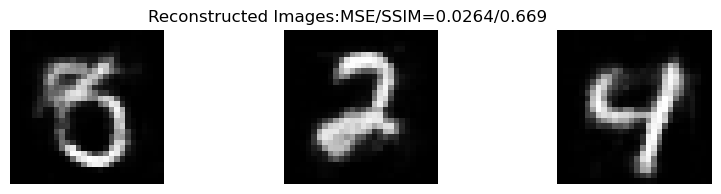

α=0.20 3th Epoch: 9/10

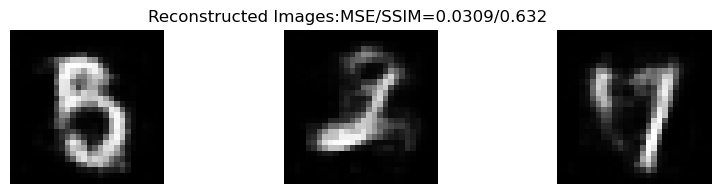

α=0.20 4th Epoch: 9/10

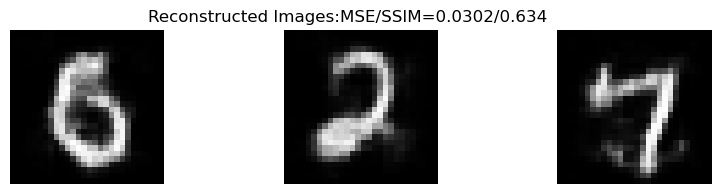

α=0.20 5th Epoch: 9/10

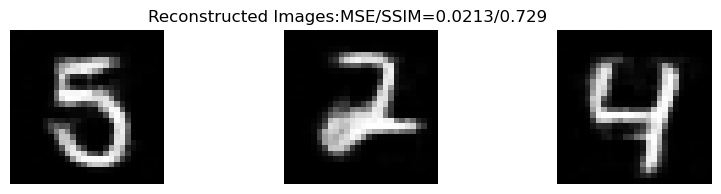

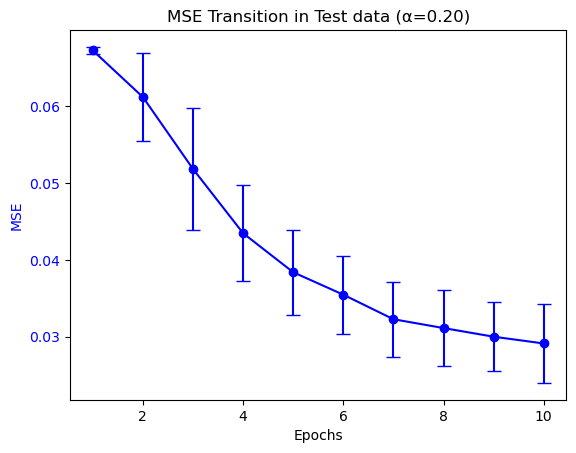

α=0.40 1th Epoch: 0/10

     α Metrics   Average  Best ID      Best  Worst ID     Worst
0  0.2    SSIM  0.649683        5  0.729273         1  0.584401
1  0.2     MSE  0.029122        5  0.021310         1  0.036798
     Index  Processing Time
0        1      1080.767842
1        2      1068.133393
2        3      1026.393170
3        4      1026.691876
4        5      1022.718559
   Average      1044.940968


α=0.40 1th Epoch: 9/10

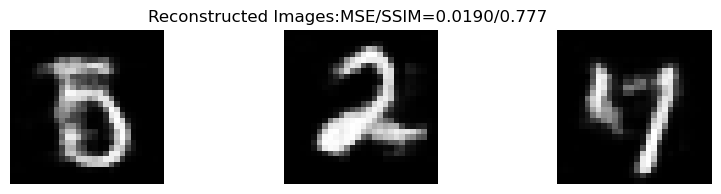

α=0.40 2th Epoch: 9/10

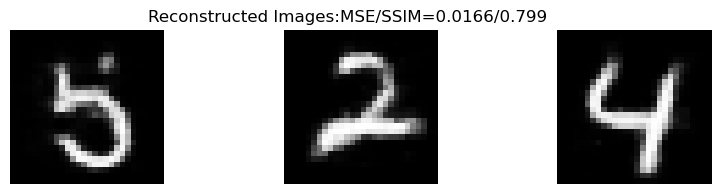

α=0.40 3th Epoch: 9/10

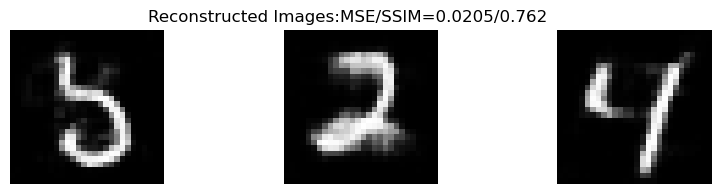

α=0.40 4th Epoch: 9/10

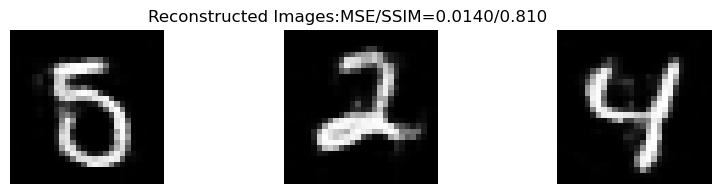

α=0.40 5th Epoch: 9/10

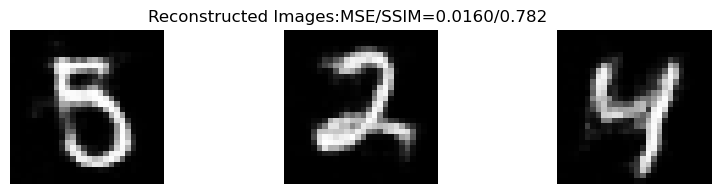

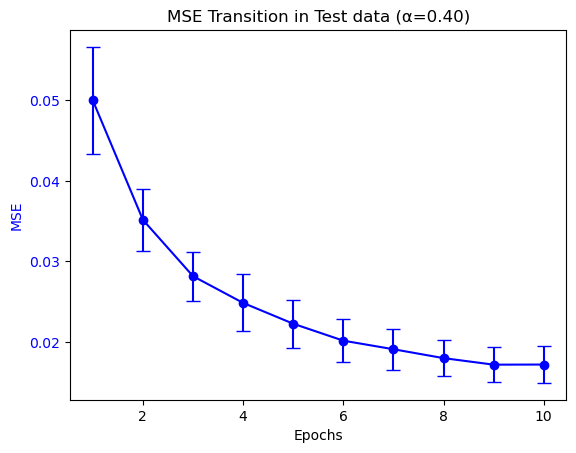

α=0.60 1th Epoch: 0/10

     α Metrics   Average  Best ID      Best  Worst ID     Worst
0  0.4    SSIM  0.786160        4  0.810168         3  0.762224
1  0.4     MSE  0.017197        4  0.013991         3  0.020472
     Index  Processing Time
0        1      1028.640200
1        2      1020.102716
2        3      1023.196946
3        4      1025.788847
4        5      1031.766144
   Average      1025.898971


α=0.60 1th Epoch: 9/10

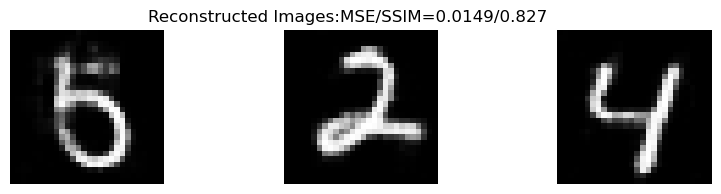

α=0.60 2th Epoch: 9/10

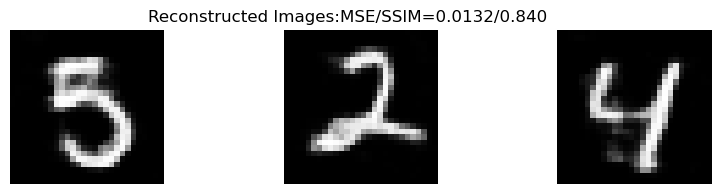

α=0.60 3th Epoch: 9/10

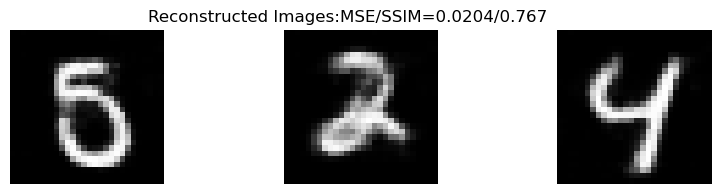

α=0.60 4th Epoch: 9/10

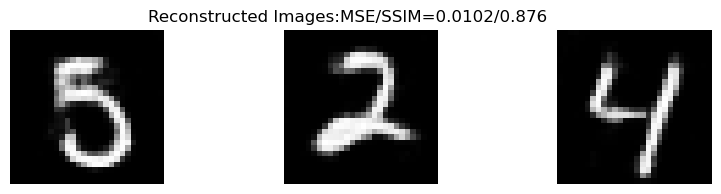

α=0.60 5th Epoch: 9/10

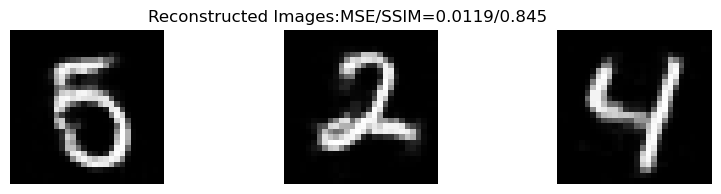

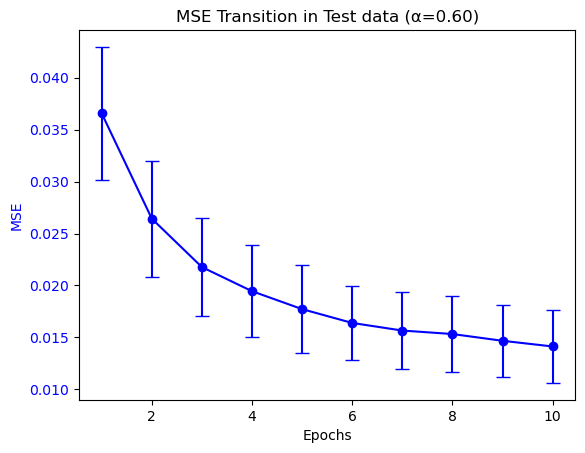

α=0.80 1th Epoch: 0/10

     α Metrics   Average  Best ID      Best  Worst ID     Worst
0  0.6    SSIM  0.831041        4  0.876474         3  0.766562
1  0.6     MSE  0.014134        4  0.010217         3  0.020426
     Index  Processing Time
0        1      1028.078072
1        2      1028.657673
2        3      1030.449296
3        4      1030.787078
4        5      1033.288714
   Average      1030.252167


α=0.80 1th Epoch: 9/10

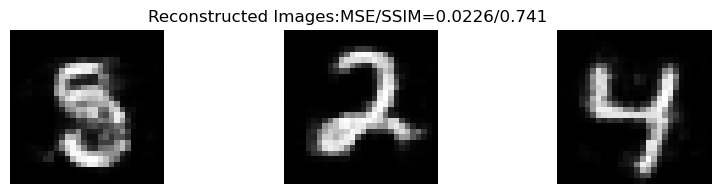

α=0.80 2th Epoch: 9/10

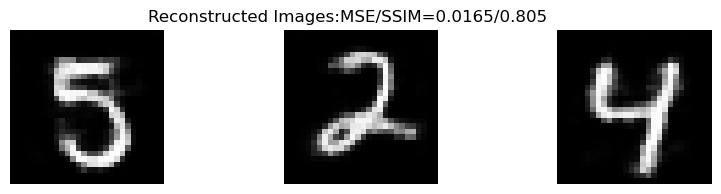

α=0.80 3th Epoch: 9/10

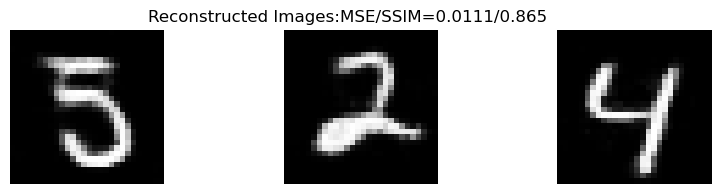

α=0.80 4th Epoch: 9/10

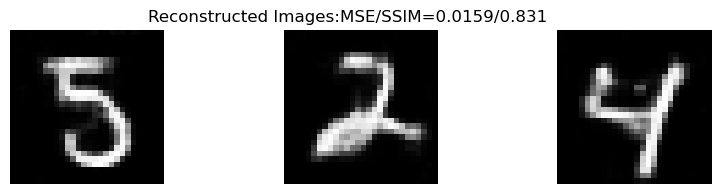

α=0.80 5th Epoch: 9/10

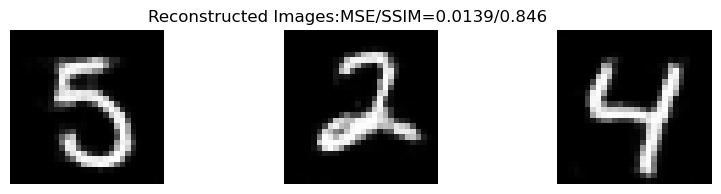

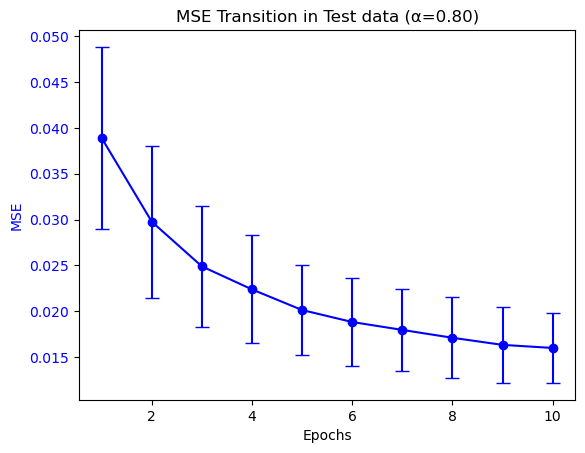

α=1.00 1th Epoch: 0/10

     α Metrics   Average  Best ID      Best  Worst ID     Worst
0  0.8    SSIM  0.817560        3  0.864672         1  0.741051
1  0.8     MSE  0.015986        3  0.011055         1  0.022616
     Index  Processing Time
0        1      1024.479623
1        2      1024.512758
2        3      1027.399167
3        4      1024.514075
4        5      1027.553205
   Average      1025.691766


α=1.00 1th Epoch: 9/10

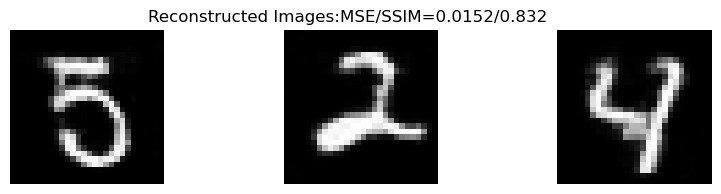

α=1.00 2th Epoch: 9/10

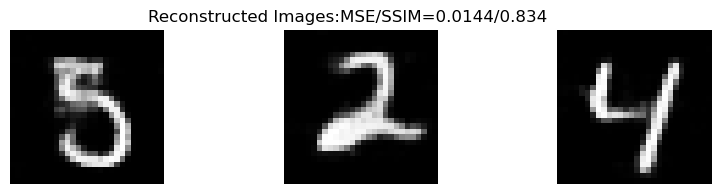

α=1.00 3th Epoch: 9/10

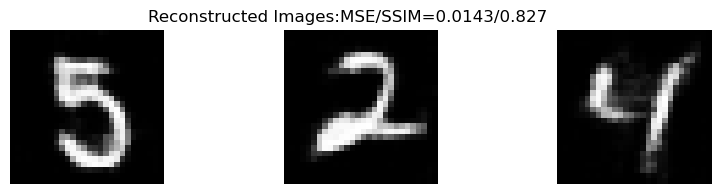

α=1.00 4th Epoch: 9/10

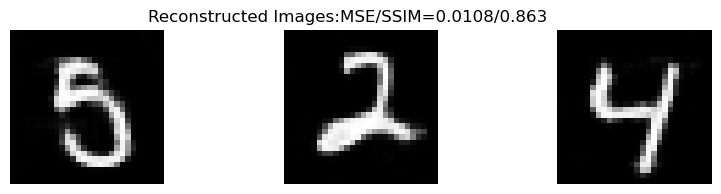

α=1.00 5th Epoch: 9/10

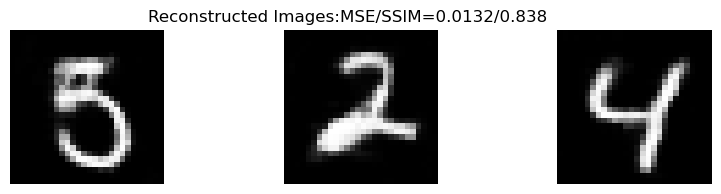

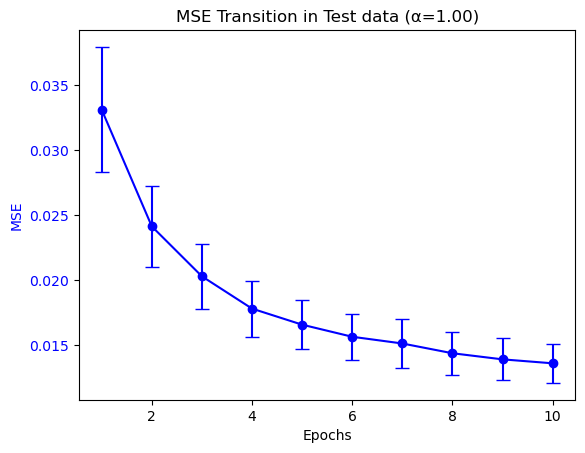

α=1.20 1th Epoch: 0/10

     α Metrics   Average  Best ID      Best  Worst ID     Worst
0  1.0    SSIM  0.838931        4  0.862567         3  0.827050
1  1.0     MSE  0.013578        4  0.010842         1  0.015167
     Index  Processing Time
0        1      1026.952632
1        2      1020.424729
2        3      1024.370164
3        4      1023.389201
4        5      1023.950250
   Average      1023.817395


α=1.20 1th Epoch: 9/10

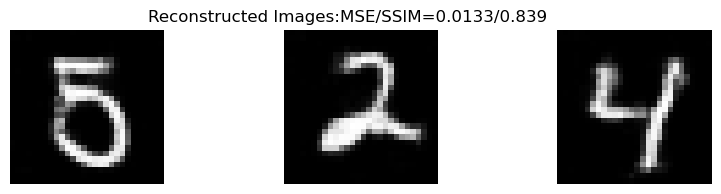

α=1.20 2th Epoch: 9/10

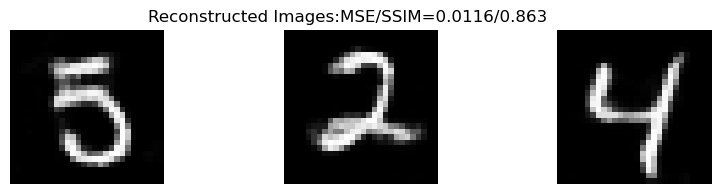

α=1.20 3th Epoch: 9/10

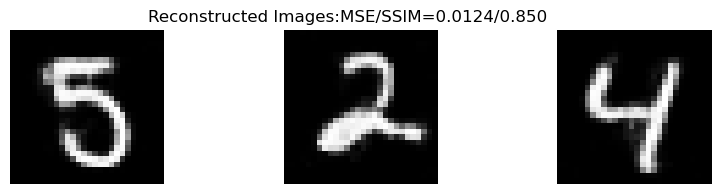

α=1.20 4th Epoch: 9/10

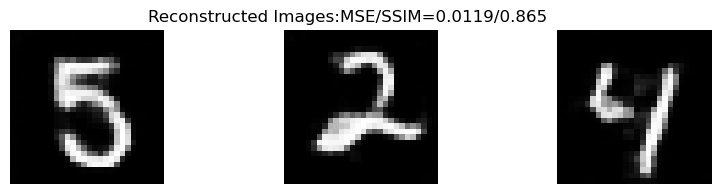

α=1.20 5th Epoch: 9/10

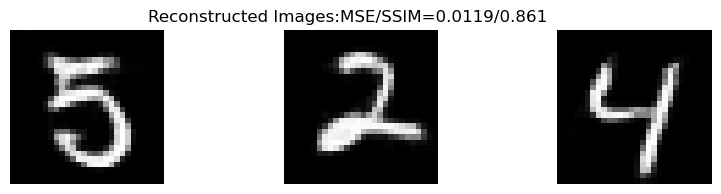

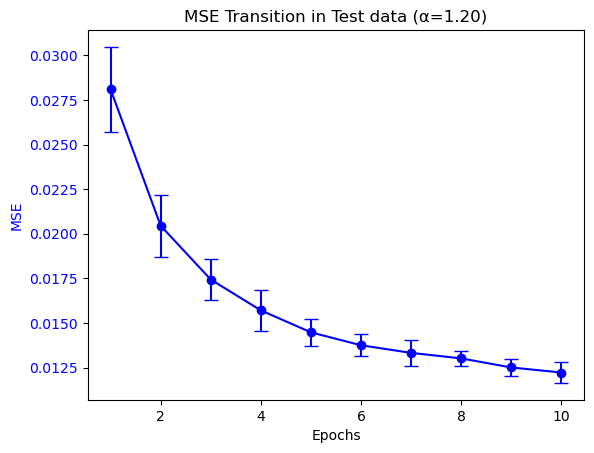

α=1.40 1th Epoch: 0/10

     α Metrics   Average  Best ID      Best  Worst ID     Worst
0  1.2    SSIM  0.855559        4  0.864660         1  0.839431
1  1.2     MSE  0.012222        2  0.011628         1  0.013278
     Index  Processing Time
0        1      1035.131406
1        2      1020.397431
2        3      1021.015408
3        4      1032.398555
4        5      1031.246135
   Average      1028.037787


α=1.40 1th Epoch: 9/10

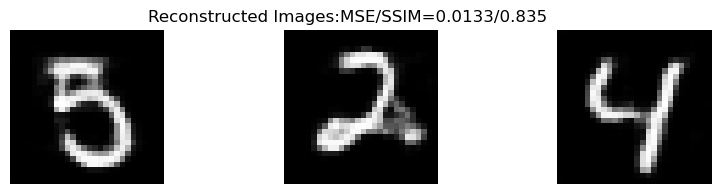

α=1.40 2th Epoch: 9/10

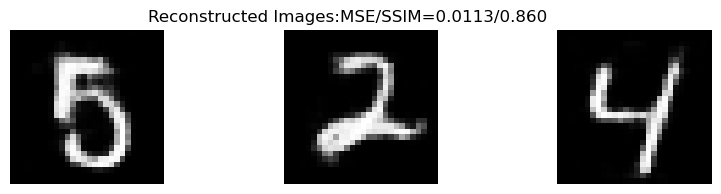

α=1.40 3th Epoch: 9/10

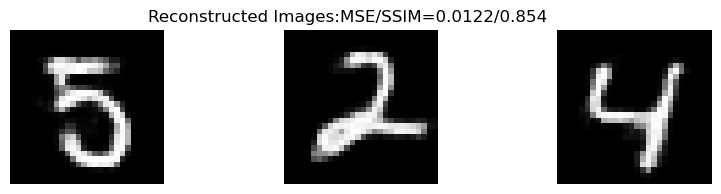

α=1.40 4th Epoch: 9/10

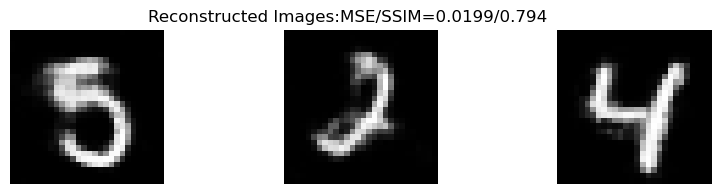

α=1.40 5th Epoch: 9/10

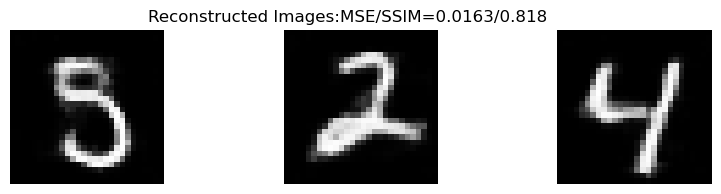

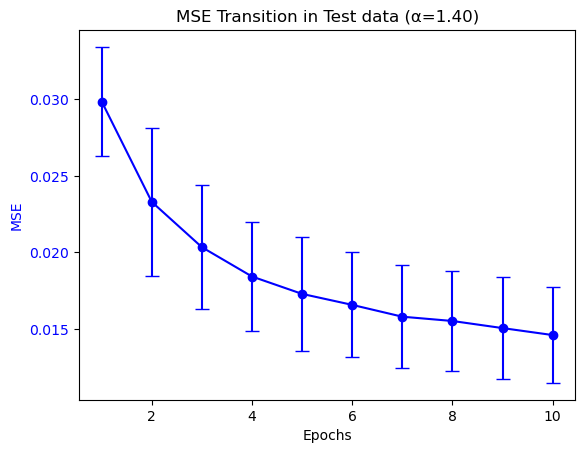

α=1.60 1th Epoch: 0/10

     α Metrics   Average  Best ID      Best  Worst ID     Worst
0  1.4    SSIM  0.832093        2  0.859929         4  0.793845
1  1.4     MSE  0.014601        2  0.011329         4  0.019886
     Index  Processing Time
0        1      1034.517245
1        2      1027.846010
2        3      1031.327354
3        4      1028.994015
4        5      1026.465458
   Average      1029.830017


α=1.60 1th Epoch: 9/10

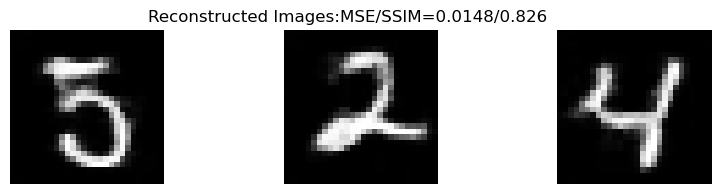

α=1.60 2th Epoch: 9/10

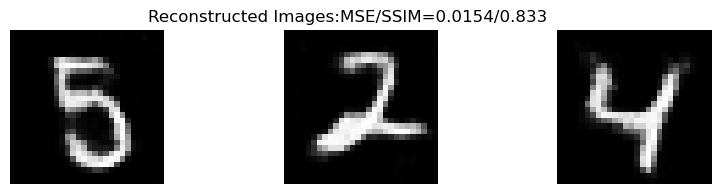

α=1.60 3th Epoch: 9/10

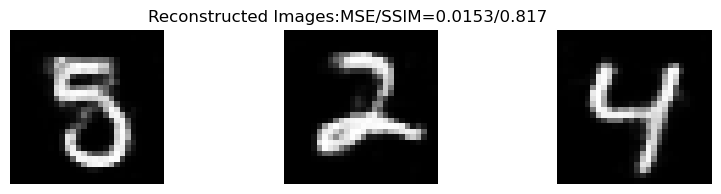

α=1.60 4th Epoch: 9/10

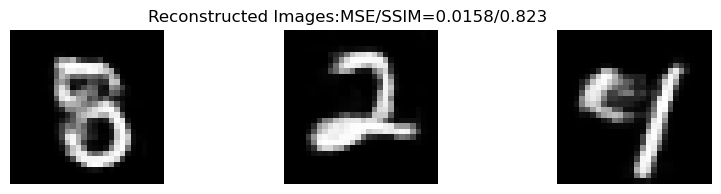

α=1.60 5th Epoch: 9/10

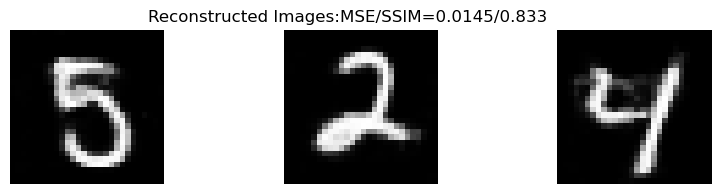

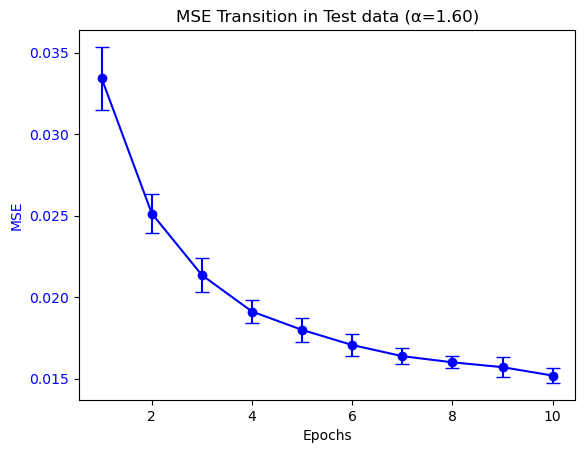

     α Metrics   Average  Best ID      Best  Worst ID     Worst
0  1.6    SSIM  0.826310        2  0.833457         3  0.816667
1  1.6     MSE  0.015189        5  0.014549         4  0.015823
     Index  Processing Time
0        1      1026.845256
1        2      1026.270335
2        3      1028.108812
3        4      1024.505281
4        5      1018.906825
   Average      1024.927302


In [28]:
DofIN = 784 ####圧縮倍率
kernel_size = 4 #カーネルサイズ
ch = 40
pos_embed_dim = 5
max_epochs = 10##
num_try = 5##
leverage = 8

alphas = [0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6] 
results = []
All_last_MSEs_ = []
All_last_SSIMs_ = []

for alpha in alphas: 
    
    All_last_loss = []
    All_last_ssim = []
    All_loss_test = []
    All_pro_time = []

    for num_times in range(1,num_try+1): 

        model = AutoEncoder(DofIN,kernel_size,leverage,ch,pos_embed_dim,alpha).to(device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        
        loss_train_ = []
        loss_test_ = []
        pro_time_ = []

                
        for epoch in range(max_epochs):

            sys.stderr.write('\rα=%.2f %dth Epoch: %d/%d' % (alpha,num_times, epoch, max_epochs)) 
            sys.stderr.flush()

            loss_train = 0
            loss_test = 0

            start_time1 = time.time()
            for (x,t) in train_dataloader:
                        
                x, t = x.to(device), t.to(device)
                y = model(x).to(device)
                loss = criterion(y, x.view(x.size(0), -1)) 
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                loss_train += loss.item()
        
            loss_train_avg = loss_train / len(train_dataloader)
            end_time1 = time.time()
            pro_time_.append(end_time1-start_time1)


            with torch.no_grad():
                for x, t in test_dataloader:
                    x, t = x.to(device), t.to(device)
                    y = model(x).to(device)
                    loss = criterion(y, x.view(x.size(0), -1))
            
                    loss_test += loss.item()

            loss_test_avg = loss_test / len(test_dataloader)

            loss_train_.append(loss_train_avg)
            loss_test_.append(loss_test_avg)
            
            if epoch == max_epochs-1:
                All_loss_test.append(loss_test_)
                All_pro_time.append(sum(pro_time_)) 
                ssim_test = ssim_loss(y.view(-1, 1, 28, 28),x.view(-1, 1, 28, 28)).item()
                All_last_ssim.append(ssim_test) 
        Last_loss_test = loss_test_[-1]
        All_last_loss.append(Last_loss_test)#特定のleverageにおけるlastmse


        with torch.no_grad():
            test_images = test_images.to(device)
            reconstructed_images = model(test_images)
            image_title = "Reconstructed Images:MSE/SSIM=%.4f/%.3f"%(Last_loss_test,ssim_test)
            show_images(reconstructed_images.cpu(),test_labels, image_title)
            file_name = '%d_ReImage(α%.2f)%dth.png'%(int(formatted_date),alpha,num_times)
            full_path = os.path.join(save_directory, file_name)
            plt.savefig(full_path, dpi=100, bbox_inches='tight')
            plt.show()

    All_last_MSEs_.append(All_last_loss)
    All_last_SSIMs_.append(All_last_ssim)

    epochs = len(All_loss_test[0]) 
    num_dimensions = len(All_loss_test)
    mean_loss = np.mean(All_loss_test, axis=0)
    std_loss = np.std(All_loss_test, axis=0)

    fig, ax1 = plt.subplots()

    ax1.errorbar(
        x=range(1, epochs + 1), y=mean_loss, yerr=std_loss,
        fmt='-o', color='blue', ecolor='blue', capsize=5, 
    )

    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('MSE', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    plt.title('MSE Transition in Test data (α=%.2f)' % alpha)
    file_name = '%d_MSE_errorbar(α%.2f).png'%(int(formatted_date),alpha)
    full_path = os.path.join(save_directory, file_name)
    plt.savefig(full_path, dpi=100, bbox_inches='tight')
    plt.show()

    SSIM_mean = np.mean(All_last_ssim)
    SSIM_best = np.max(All_last_ssim)
    SSIM_bestID = np.argmax(All_last_ssim)+1
    SSIM_worst = np.min(All_last_ssim)
    SSIM_worstID = np.argmin(All_last_ssim)+1

    MSE_mean = np.mean(All_last_loss)
    MSE_best = np.min(All_last_loss)
    MSE_bestID = np.argmin(All_last_loss)+1
    MSE_worst = np.max(All_last_loss)
    MSE_worstID = np.argmax(All_last_loss)+1

    data = {
        "α":[alpha,alpha],
        "Metrics": ["SSIM", "MSE"],
        "Average": [SSIM_mean, MSE_mean,],
        "Best ID": [SSIM_bestID, MSE_bestID,],
        "Best": [SSIM_best, MSE_best],
        "Worst ID": [SSIM_worstID, MSE_worstID],
        "Worst": [SSIM_worst, MSE_worst],
    }
    df = pd.DataFrame(data)
    results.append(data)
    print(df)

    pro_time_mean = sum(All_pro_time)/len(All_pro_time)
    data2 = {
        "Index": list(range(1, len(All_pro_time) + 1)),  # インデックス（1から開始）
        "Processing Time": All_pro_time                # 各処理時間
    }
    df2 = pd.DataFrame(data2)
    df2.loc[""] = ["Average", pro_time_mean]
    print(df2)


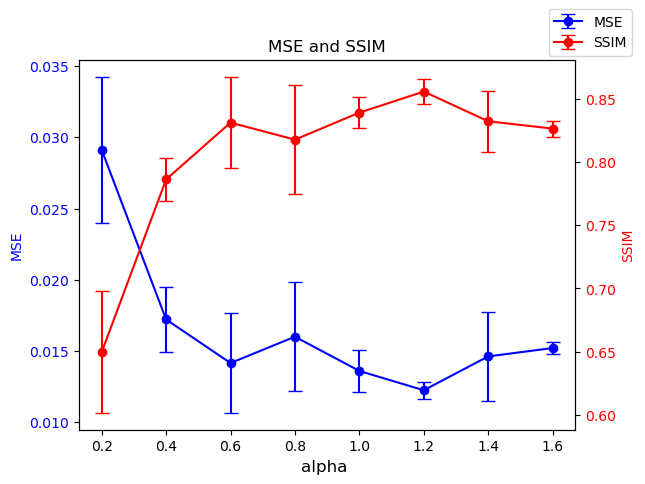

In [29]:

x_values = [alpha for alpha in alphas]

# MSE用の平均値と標準偏差を計算
mse_means = [np.mean(mse_list) for mse_list in All_last_MSEs_]
mse_stds = [np.std(mse_list) for mse_list in All_last_MSEs_]

# SSIM用の平均値と標準偏差を計算
ssim_means = [np.mean(ssim_list) for ssim_list in All_last_SSIMs_]
ssim_stds = [np.std(ssim_list) for ssim_list in All_last_SSIMs_]

# グラフの描画
fig, ax1 = plt.subplots()

# MSEのエラーバー付き折れ線グラフ
ax1.errorbar(
    x=x_values, y=mse_means, yerr=mse_stds,
    fmt='-o', color='blue', ecolor='blue', capsize=5, label='MSE'
)
ax1.set_ylabel('MSE', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
# SSIMのエラーバー付き折れ線グラフ
ax2.errorbar(
    x=x_values, y=ssim_means, yerr=ssim_stds,
    fmt='-o', color='red', ecolor='red', capsize=5, label='SSIM'
)
ax2.set_ylabel('SSIM', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# 軸ラベルとスケールの設定
ax1.set_xlabel('alpha ', fontsize=12)
'''ax1.set_xticks(x_values)
ax1.set_xticklabels(["1:%d" % leverage for leverage in leverages], fontsize=10)'''  # ラベルを「1:N」形式で表示

# タイトルと凡例
plt.title('MSE and SSIM', fontsize=14)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
fig.legend(
    lines1 + lines2, labels1 + labels2, loc="upper right", bbox_to_anchor=(1, 1)
)


title = 'MSE and SSIM' #
plt.title(title)
file_name = '%d_MSEandSSIM.png'%(int(formatted_date))
full_path = os.path.join(save_directory, file_name)
plt.savefig(full_path, dpi=100, bbox_inches='tight')
plt.show()

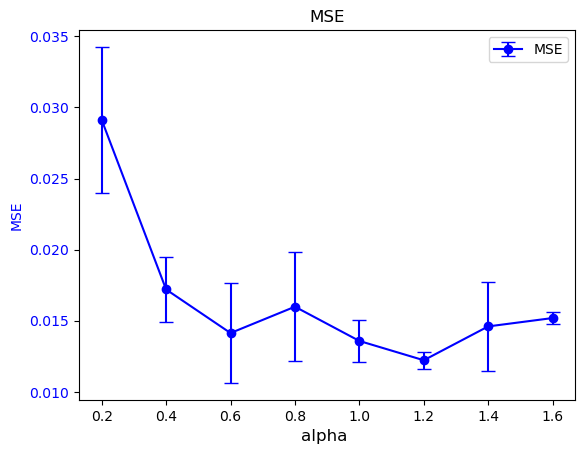

In [30]:
fig, ax1 = plt.subplots()

ax1.errorbar(
    x=x_values, y=mse_means, yerr=mse_stds,
    fmt='-o', color='blue', ecolor='blue', capsize=5, label='MSE'
)
ax1.set_ylabel('MSE', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax1.set_xlabel('alpha ', fontsize=12)
'''ax1.set_xticks(x_values)
ax1.set_xticklabels(["1:%d" % leverage for leverage in leverages], fontsize=10) ''' 

ax1.legend()
title = 'MSE' #
plt.title(title)
file_name = '%d_MSEperRatio.png'%(int(formatted_date))
full_path = os.path.join(save_directory, file_name)
plt.savefig(full_path, dpi=100, bbox_inches='tight')
plt.show()

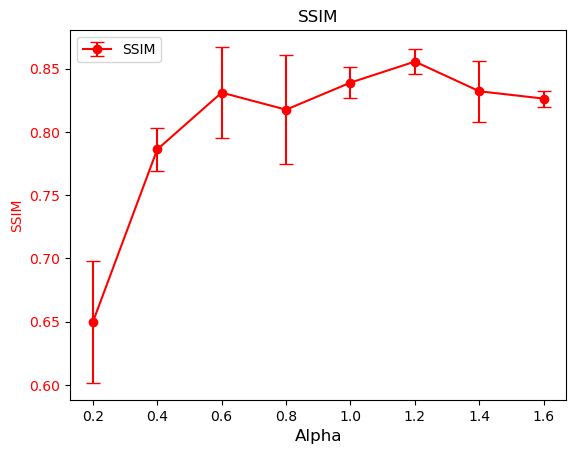

In [31]:
fig, ax1 = plt.subplots()

ax1.errorbar(
    x=x_values, y=ssim_means, yerr=ssim_stds,
    fmt='-o', color='red', ecolor='red', capsize=5, label='SSIM'
)
ax1.set_ylabel('SSIM', color='red')
ax1.tick_params(axis='y', labelcolor='red')

ax1.set_xlabel('Alpha', fontsize=12)
'''ax1.set_xticks(x_values)
ax1.set_xticklabels(["1:%d" % leverage for leverage in leverages], fontsize=10'''

ax1.legend()
title = 'SSIM' #
plt.title(title)
file_name = '%d_SSIMperRatio.png'%(int(formatted_date))
full_path = os.path.join(save_directory, file_name)
plt.savefig(full_path, dpi=100, bbox_inches='tight')
plt.show()

In [32]:
all_data = pd.concat([pd.DataFrame(result) for result in results], ignore_index=True)
print(all_data)
file_name = '%d_exTable.csv'%(int(formatted_date))
full_path = os.path.join(save_directory, file_name)
all_data.to_csv(full_path, index=False)

      α Metrics   Average  Best ID      Best  Worst ID     Worst
0   0.2    SSIM  0.649683        5  0.729273         1  0.584401
1   0.2     MSE  0.029122        5  0.021310         1  0.036798
2   0.4    SSIM  0.786160        4  0.810168         3  0.762224
3   0.4     MSE  0.017197        4  0.013991         3  0.020472
4   0.6    SSIM  0.831041        4  0.876474         3  0.766562
5   0.6     MSE  0.014134        4  0.010217         3  0.020426
6   0.8    SSIM  0.817560        3  0.864672         1  0.741051
7   0.8     MSE  0.015986        3  0.011055         1  0.022616
8   1.0    SSIM  0.838931        4  0.862567         3  0.827050
9   1.0     MSE  0.013578        4  0.010842         1  0.015167
10  1.2    SSIM  0.855559        4  0.864660         1  0.839431
11  1.2     MSE  0.012222        2  0.011628         1  0.013278
12  1.4    SSIM  0.832093        2  0.859929         4  0.793845
13  1.4     MSE  0.014601        2  0.011329         4  0.019886
14  1.6    SSIM  0.826310

In [33]:
'''import csv
save_directory1 = os.path.join(onedrive_path,'CODES', 'konishi_AutoEncoder', 'AutoEncoder_data02','texts') 
print(save_directory1)
os.makedirs(save_directory1, exist_ok=True)
file_name = 'MNIST_[004]αC_list.csv'##
full_path = os.path.join(save_directory1, file_name)
with open(full_path, mode='w', newline='') as file:
    writer = csv.writer(file)

    writer.writerow(All_last_MSEs_)
    writer.writerow(All_last_SSIMs_)'''

"import csv\nsave_directory1 = os.path.join(onedrive_path,'CODES', 'konishi_AutoEncoder', 'AutoEncoder_data02','texts') \nprint(save_directory1)\nos.makedirs(save_directory1, exist_ok=True)\nfile_name = 'MNIST_[004]αC_list.csv'##\nfull_path = os.path.join(save_directory1, file_name)\nwith open(full_path, mode='w', newline='') as file:\n    writer = csv.writer(file)\n\n    writer.writerow(All_last_MSEs_)\n    writer.writerow(All_last_SSIMs_)"